![ ](https://raw.githubusercontent.com/darialukash/data_analysis_projects/master/superconduct-data/superconductor-720x720.jpg)

# Predicting the critical temperature of a superconductor

<center>
    
### Part 1. Dataset and features description

**DATASET**

There are two files:
* train.csv contains 81 features extracted from 21263 superconductors along with the critical temperature in the 82nd column
* unique_m.csv contains the chemical formula broken up for all the 21263 superconductors from the train.csv file. The last two columns have the critical temperature and chemical formula.

The superconductor data comes from the Superconducting Material Database maintained by Japan’s National Institute for Materials Science (NIMS) at http://supercon.nims.go.jp/index_en.html.

The goal here is to predict the critical temperature (*Tc*) based on the features extracted.

**Description**

*Superconducting materials* - materials that conduct current with zero resistance - have significant
practical applications.

Perhaps the best known application is in the *Magnetic Resonance Imaging (MRI)* systems widely employed by health care professionals for detailed internal body imaging.

Other prominent applications include the superconducting coils used to maintain high magnetic fields in the Large Hadron Collider at CERN, where the existence of Higgs Boson was recently confirmed, and the extremely sensitive magnetic field measuring devices called *SQUIDs (Superconducting Quantum Interference Devices)*.

Furthermore, superconductors could revolutionize the energy industry as frictionless (zero resistance) superconducting wires and electrical system may transport and deliver electricity with no energy loss; see Hassenzahl (2000).


However, the wide spread applications of superconductors have been held back by two major issues: 
* A superconductor conducts current with zero resistance only at or below its superconducting critical temperature (*Tc*). Often impractically, a superconductor must be cooled to extremely low temperatures near or below the boiling temperature of nitrogen (77 K) before exhibiting the zero resistance property.
* The scientific model and theory that predicts *Tc* is an open problem which has been baffling the scientific community since the discovery of superconductivity in 1911 by Heike Kamerlingh Onnes, in Leiden. 

In the absence of any theory-based prediction models, simple empirical rules based on experimental results have guided researchers in synthesizing superconducting materials for many years.
arXiv:1803.10260v2[https://arxiv.org/pdf/1803.10260.pdf] 12 Oct 2018

For example, the eminent experimental physicist Matthias (1955) concluded that *Tc* is related to the number of available valence electrons per atom. (A few of these rules came to be known as the Matthias’s rules.) It is now well known that many of the simple empirical rules are violated; see Conder (2016).


**Features Description**

| Variable | Units | Describtion |
| :---: | :---: | :---: |
| Atomic Mass | atomic mass units (AMU) | total proton and neutron rest masses |
| First Ionization Energy (fie) | kilo-Joules per mole (kJ/mol) | energy required to remove a valence electron |
| Atomic Radius | picometer (pm) | calculated atomic radius |
| Density | kilograms per meters cubed (kg/m^3) | density at standard temperature and pressure |
| Electron Affinity | kilo-Joules per mole (kJ/mol) | energy required to add an electron to a neutral atom |
| Fusion Heat | kilo-Joules per mole (kJ/mol) | energy to change from solid to liquid without temperature change |
| Thermal Conductivity | watts per meter-Kelvin (W/(m × K)) | thermal conductivity coefficient κ |
| Valence | no units | typical number of chemical bonds formed by the element |

![](https://raw.githubusercontent.com/darialukash/data_analysis_projects/master/superconduct-data/physical_formulas.png)

**Import Libraries**

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from functools import reduce
from matplotlib import pyplot as plt
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,\
                                                    validation_curve, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [2]:
data_path = 'superconduct-data/train.csv' # path to the data
formula_path = 'superconduct-data/unique_m.csv' # path to the chemical formula sdata

### Part 2. Exploratory and Visual data analysis. Patterns, insights, pecularities of data.

In [3]:
# Load data:

data = pd.read_csv(data_path)
formulas = pd.read_csv(formula_path)

In [4]:
print(data.shape)
data.head()

(21263, 82)


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [5]:
# NaNs:

data[data.isnull().any(axis=1)]

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp


In [6]:
# Target feature:

data['critical_temp'].describe()

count    21263.000000
mean        34.421219
std         34.254362
min          0.000210
25%          5.365000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

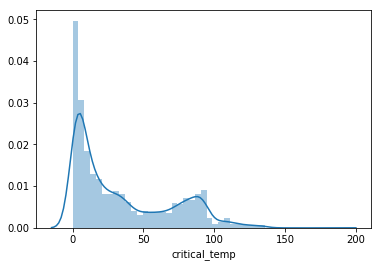

In [7]:
# Plot a univariate distribution of observations:

sns.distplot(data['critical_temp'])
plt.show()

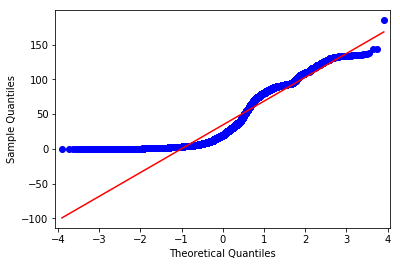

Statistics=2480.2847167522514, p-value=0.0
The null hypothesis can be rejected


In [8]:
# Q-Q plot:
qqplot(data.critical_temp, line='s')
plt.show()

# Normal distribution tests:
stat, p = normaltest(data.critical_temp)
print('Statistics={}, p-value={}'.format(stat, p))

alpha = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

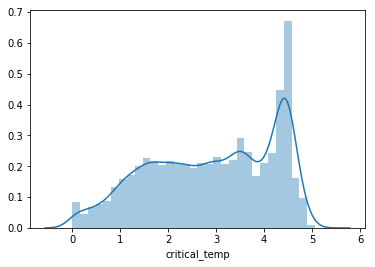

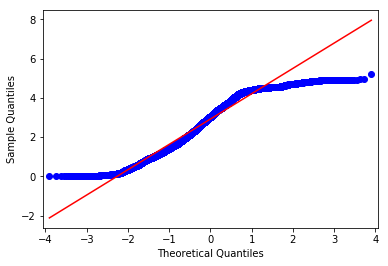

Statistics=6565.183451877896, p-value=0.0
The null hypothesis can be rejected


In [9]:
# Normality test show that the distribution is far from normal.
# Try to use function log(1+n) to make it more normal:

target_log=data['critical_temp'].apply(np.log1p)
sns.distplot(target_log)
plt.show()

qqplot(target_log, line='s')
plt.show()

stat, p = normaltest(target_log)
print('Statistics={}, p-value={}'.format(stat, p))

alpha = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

This graph looks a little better. Unfortunately, it's impossible to reconstruct clipped data and statistically the distribution it is still not normal - p-value = 0, the null hypothesis of distribution normality can be rejected.

Anyway, predicting target_log instead of the target can be a good choice.

In [10]:
# Data statistics:

data.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,...,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987,34.421219
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,...,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580,34.254362
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,32.890369,...,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892,5.365000
50%,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,45.123500,...,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000,20.000000
75%,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,59.322812,...,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


There is a list of Thermal Conductivity features, where temperature used in formula.

In [11]:
# Select features by type:

ThermalConductivity = [col for col in data.columns if col.endswith('Conductivity')]

means = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('mean_')]
wtd_means = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('wtd_mean_')]
gmeans = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('gmean_')]
wtd_gmeans = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('wtd_gmean_')]
entropy = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('entropy_')]
wtd_entropy = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('wtd_entropy_')]
wtd_range = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('wtd_range_')]
ranges = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('range_')]
stdev = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('std_')]
wtd_stdev = [col for col in data.drop(ThermalConductivity, axis=1).columns if col.startswith('wtd_std_')]

In [12]:
sns.set()

%config InlineBackend.figure_format = 'png'

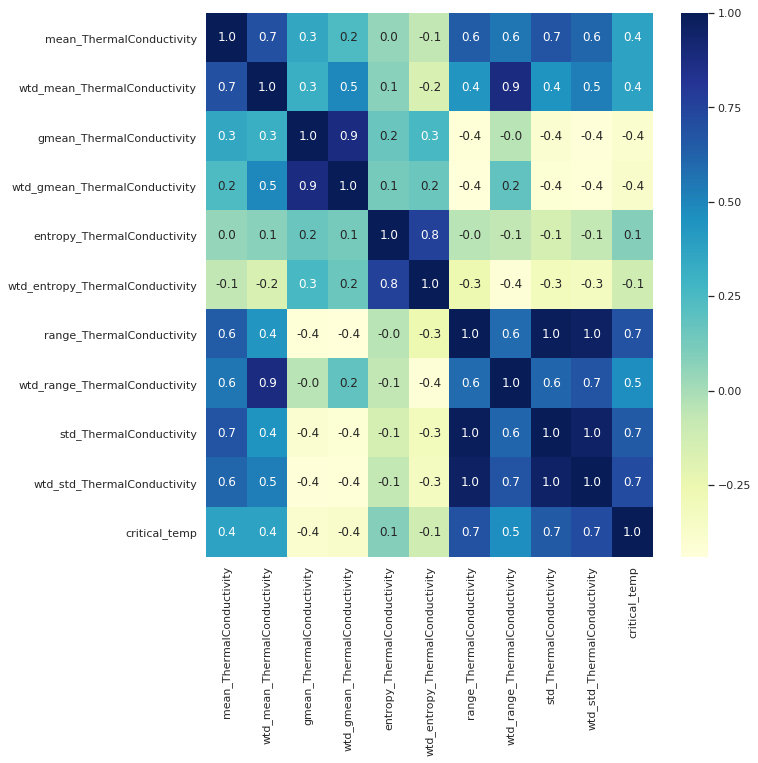

In [13]:
# Thermal conductivity features and the target relationships:

plt.figure(figsize=[10, 10])
ax = sns.heatmap(data[ThermalConductivity+['critical_temp']].corr(), 
                 fmt = ".1f", cmap='YlGnBu', cbar = True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),)
ax.set_yticklabels(ax.get_yticklabels(),)
sns.set(font_scale=1.4)
plt.show()

It can make sense to use only weighted features for other physical measurements.

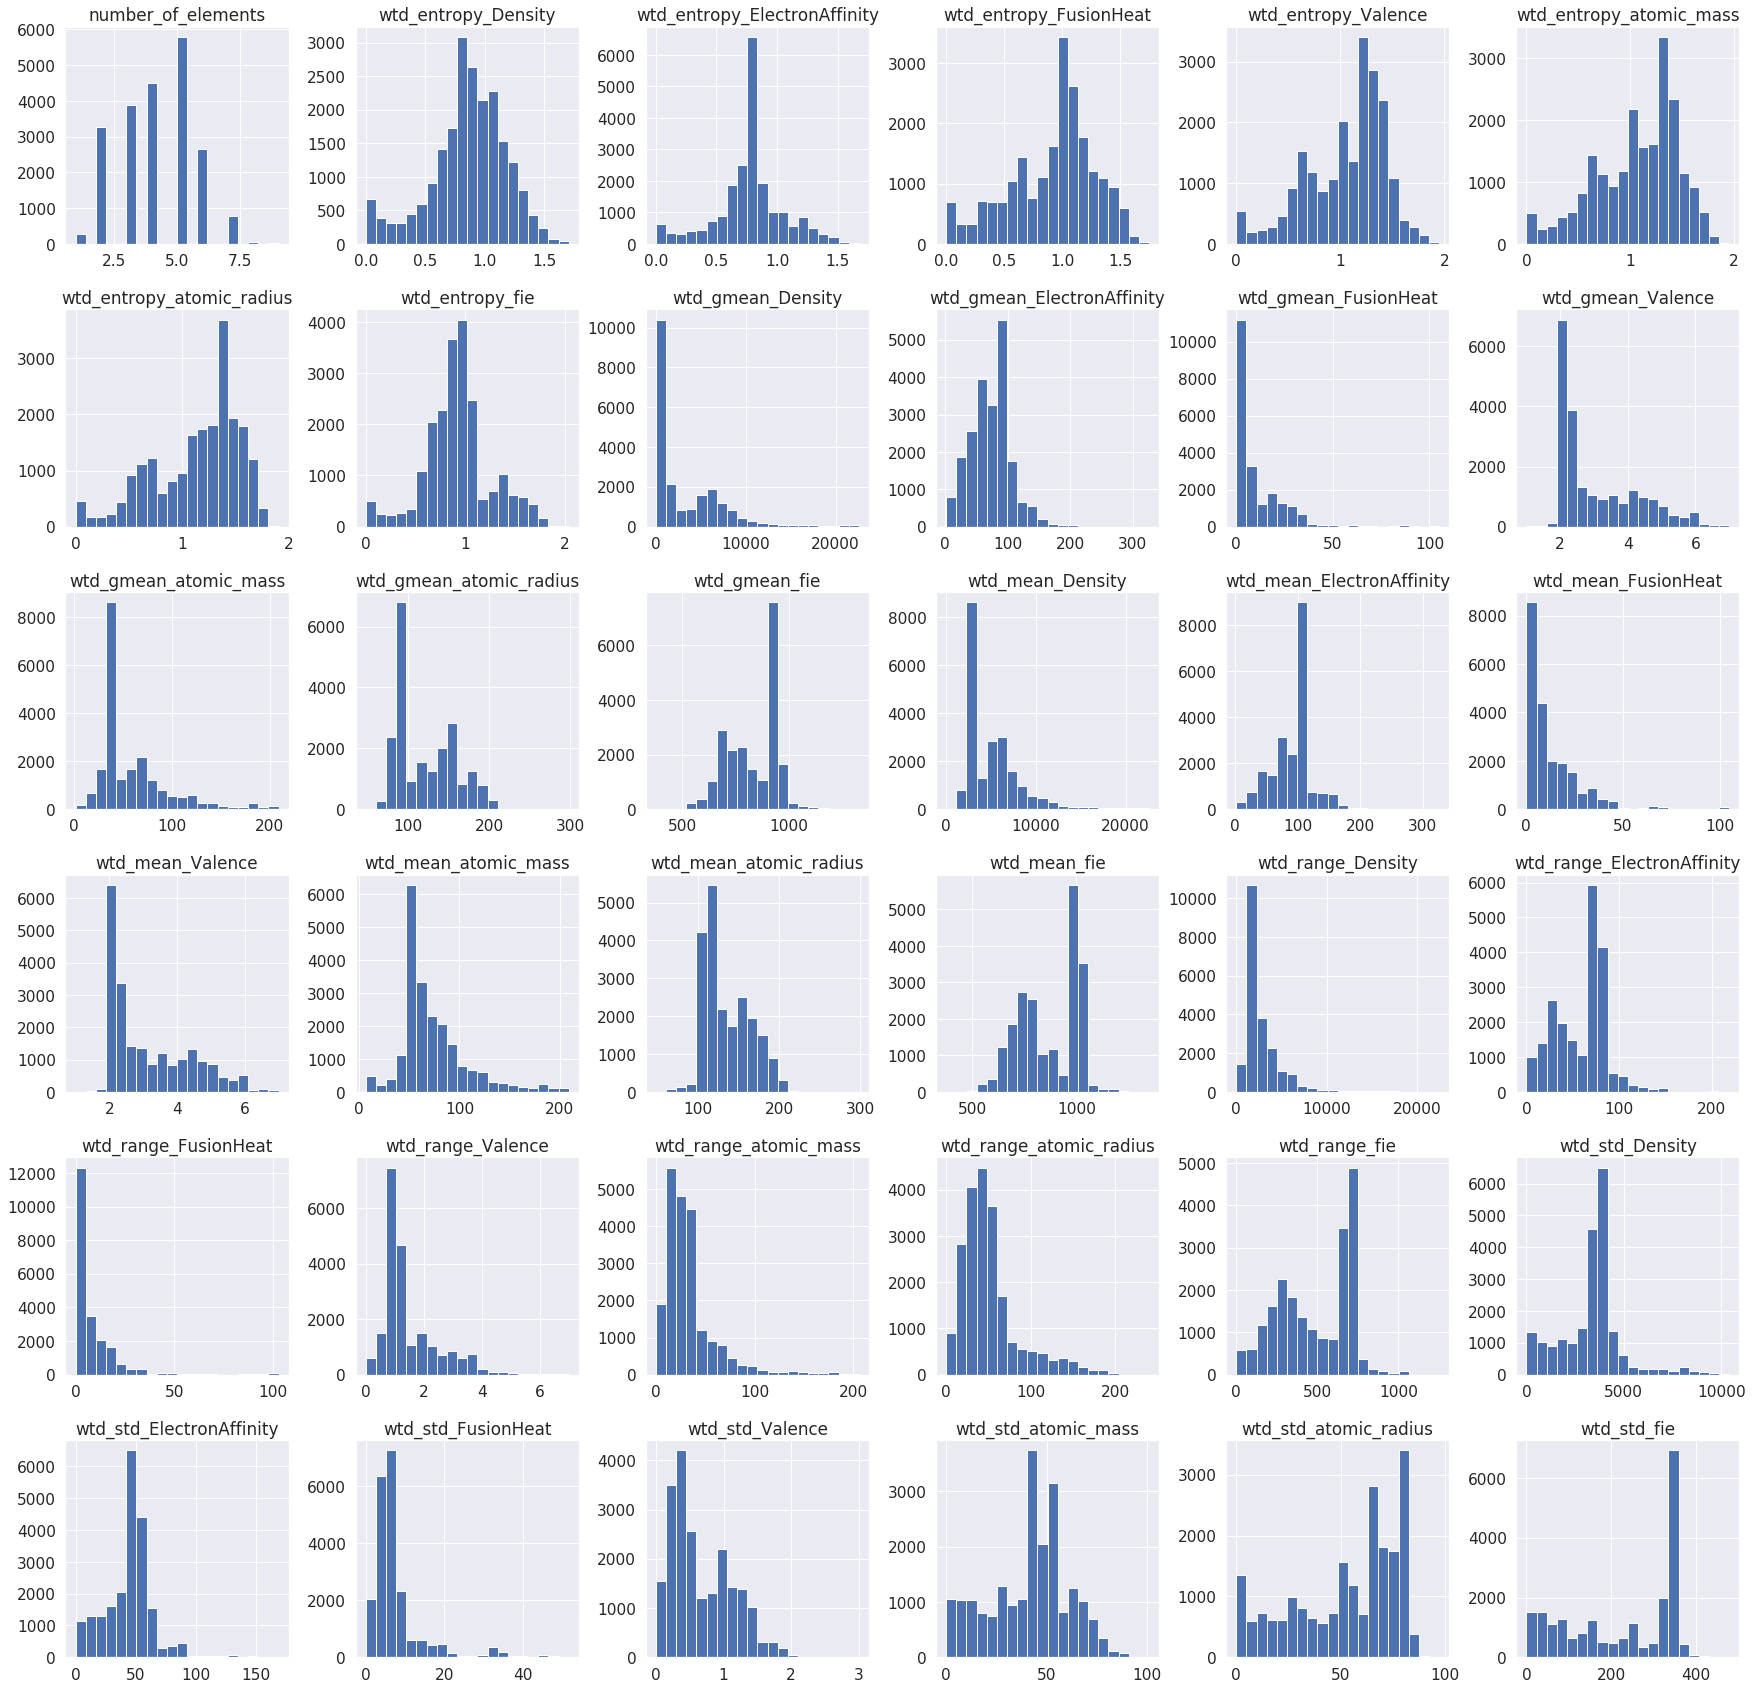

In [14]:
features = [wtd_means, wtd_gmeans, wtd_entropy, wtd_range, wtd_stdev]
features_list = reduce((lambda x, y: x+y), features)
features_list.append('number_of_elements')

data[features_list].hist(bins=20, figsize=(30, 30))
plt.show()

In [15]:
# A lot of features are significantly skewed, and "log trick" should be helpfull

temp_list = ['wtd_mean_FusionHeat', 'wtd_range_FusionHeat', 'wtd_range_atomic_mass',
             'wtd_range_atomic_radius', 'wtd_std_FusionHeat']
log_features = []
for f in temp_list:
    data['log_'+f]=data[f].apply(np.log1p)
    log_features.append('log_'+f)

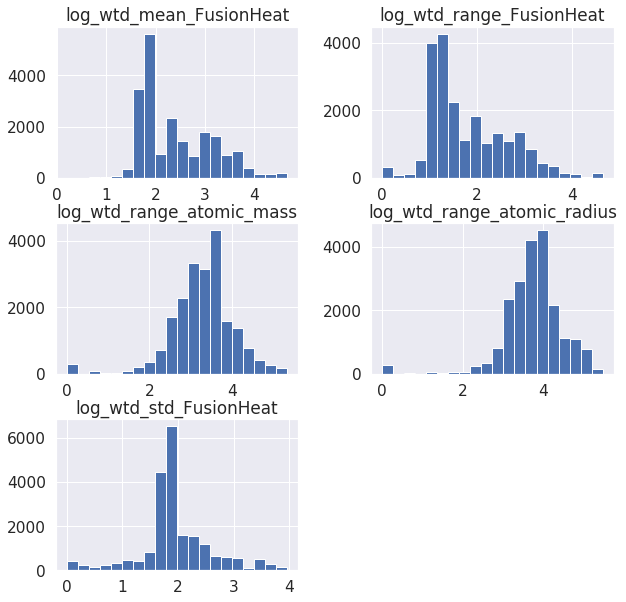

In [16]:
data[log_features].hist(bins=20, figsize=(10, 10))
plt.show()

Some new features looks much better (during the modeling phase we can use/or not use either original, new ones or both of them)

Now look at correlation matrices:

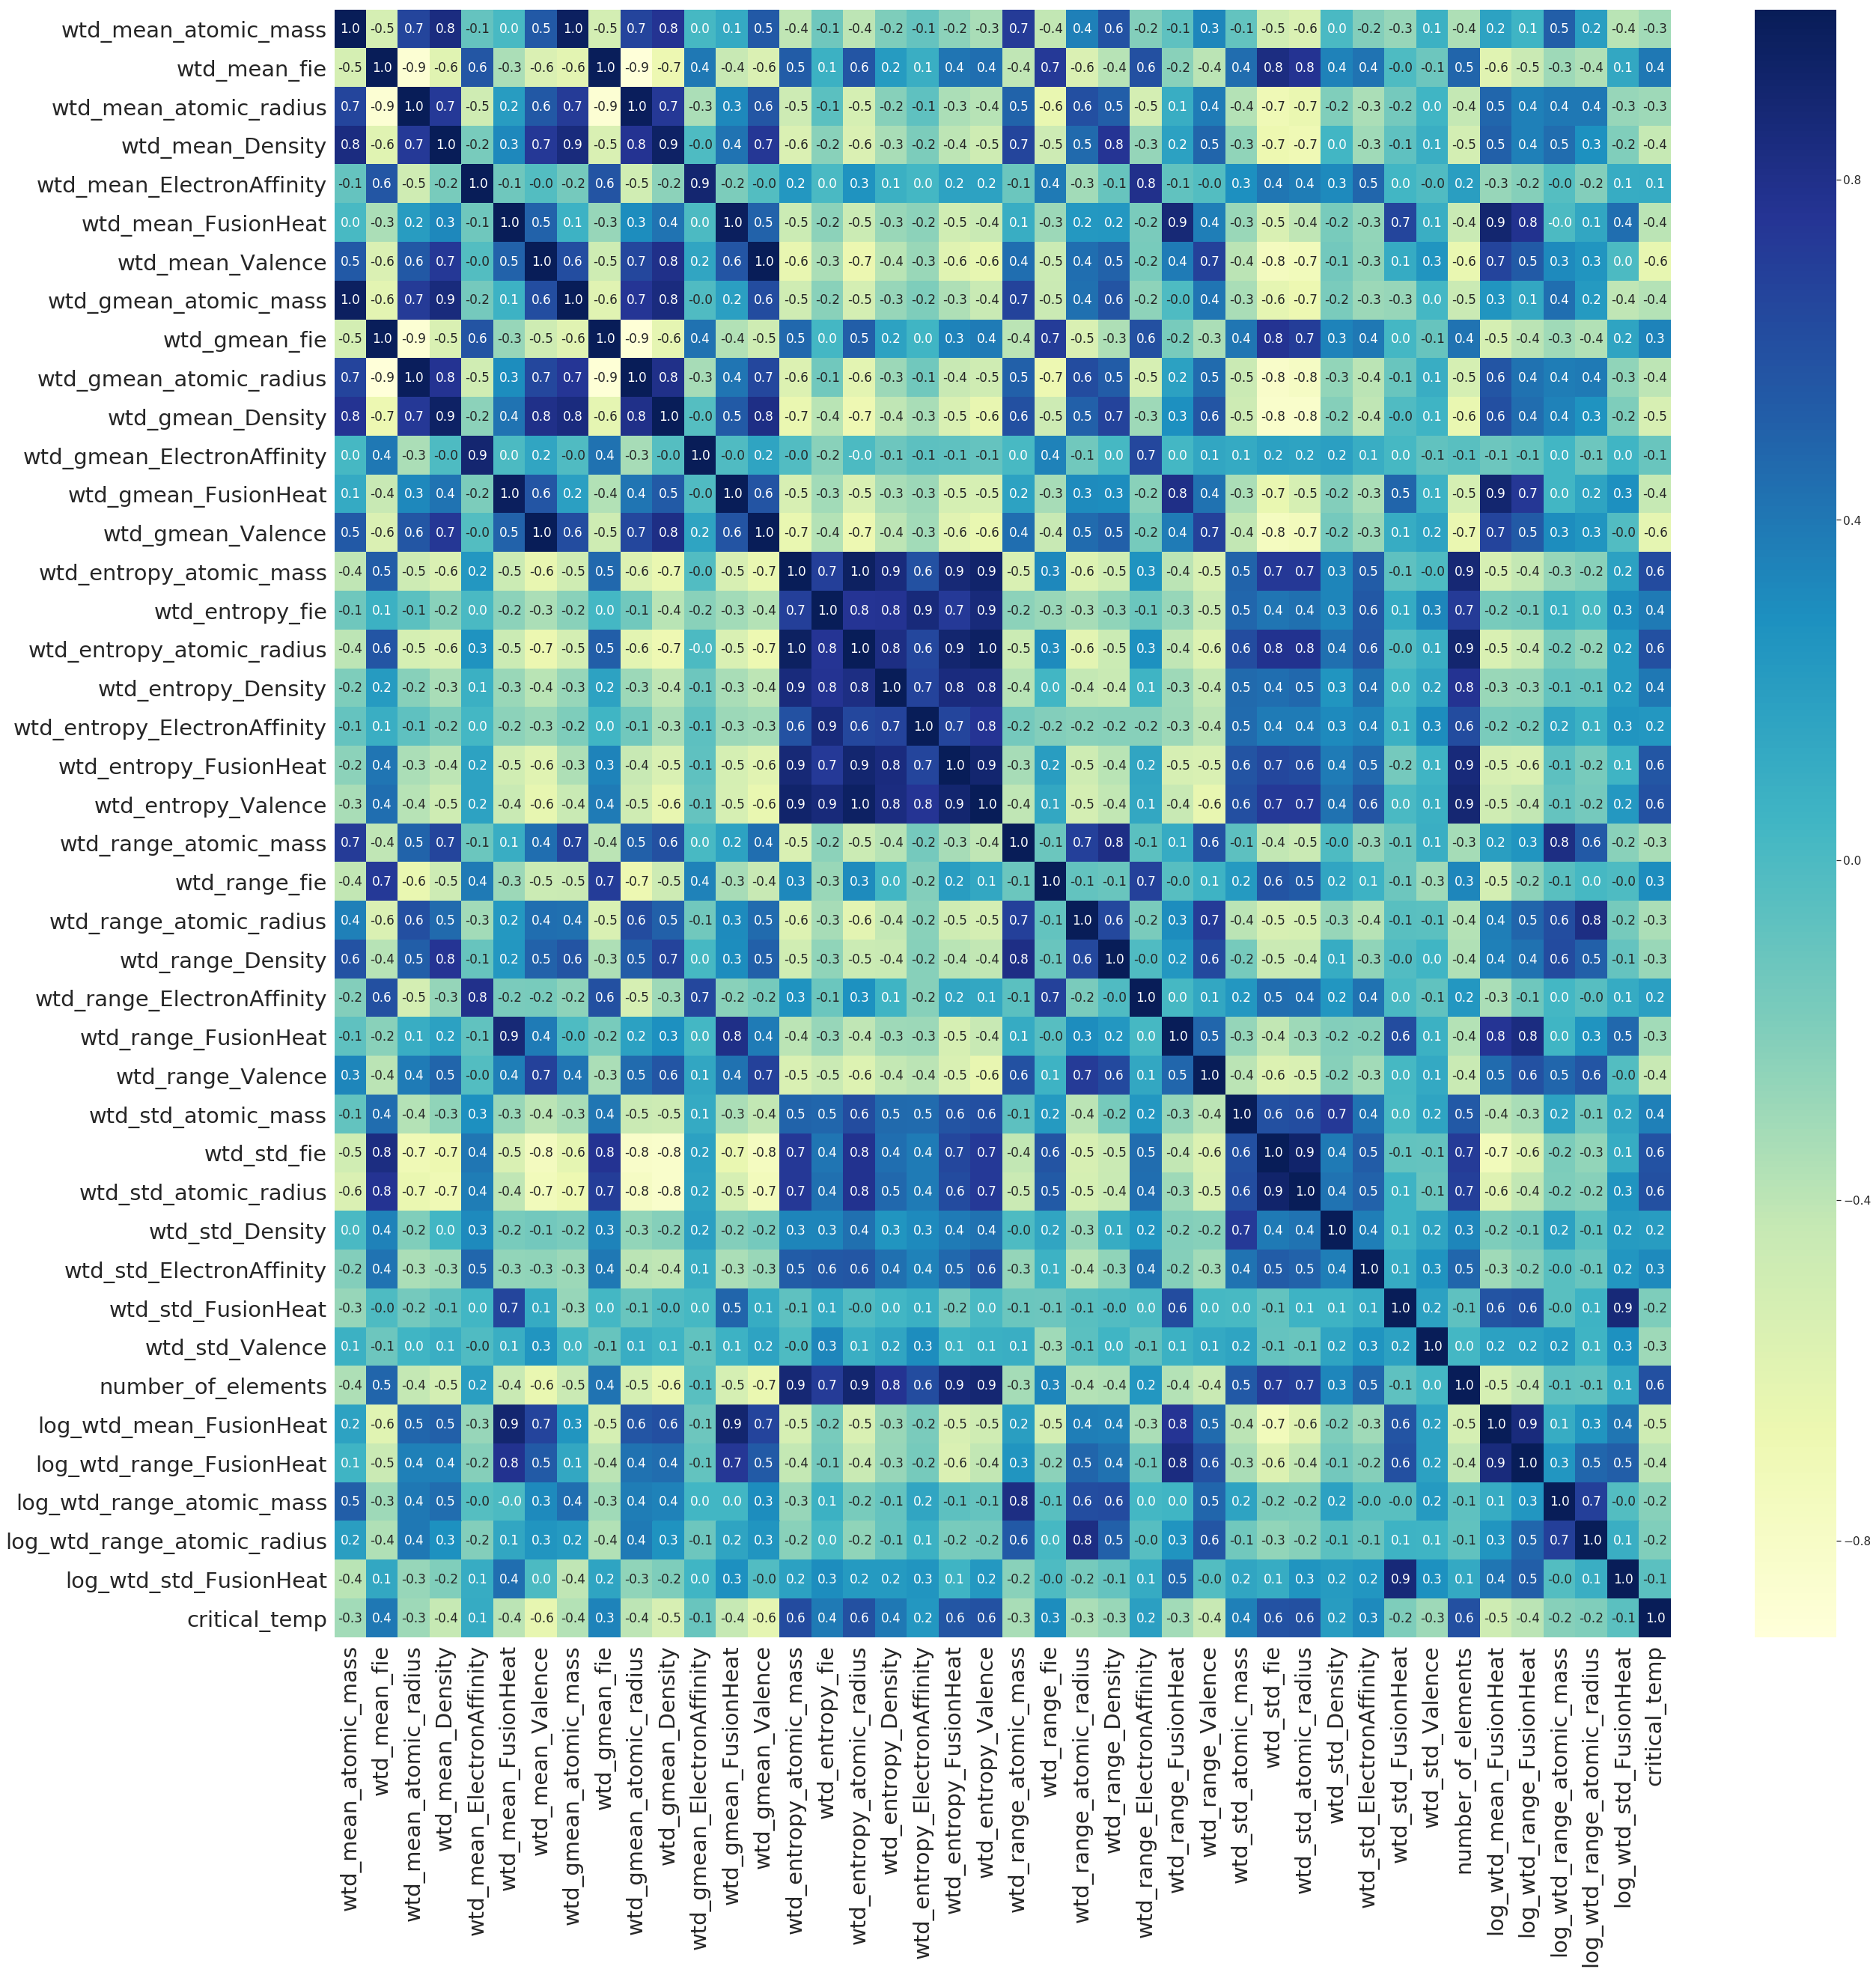

In [17]:
plt.figure(figsize=[40, 40])
ax = sns.heatmap(data[features_list+log_features+['critical_temp']].corr(), 
                 fmt = ".1f", cmap='YlGnBu', cbar = True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), size='xx-large')
ax.set_yticklabels(ax.get_yticklabels(), size='xx-large')
sns.set(font_scale=1.4)
plt.show()

Matrices have a lot ones and near ones coefficients and it's normal. Most of the features are computed from each other (see formulas above).

So, find features with correlation greater than 0.9

In [18]:
# Create correlation matrix
corr_matrix = data[features_list+log_features+['critical_temp']].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['wtd_gmean_atomic_mass', 'wtd_gmean_fie', 'wtd_gmean_atomic_radius', 'wtd_gmean_Density', 'wtd_gmean_FusionHeat', 'wtd_gmean_Valence', 'wtd_entropy_atomic_radius', 'wtd_entropy_FusionHeat', 'wtd_entropy_Valence', 'wtd_std_atomic_radius', 'number_of_elements', 'log_wtd_mean_FusionHeat']


**Second part of the dataset - chemical elements in materials:**

In [19]:
print(formulas.shape)
formulas.head()

(21263, 88)


,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [20]:
# Some element columns seem to be filled with zeros (He, Ne, etc.)
# Statistics:

formulas.describe().T[formulas.describe().T['mean'] == 0]

,count,mean,std,min,25%,50%,75%,max
He,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ne,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ar,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kr,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xe,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pm,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Po,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
At,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rn,21263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For the task of predicting the critical temperature of a superconductor I just drop that columns.

In [21]:
formulas_ = formulas.drop(['He', 'Ne', 'Ar', 'Kr', 'Xe',
                           'Pm', 'Po', 'At', 'Rn',
                           'critical_temp',
                          'material'],
                           axis=1)
formulas_.describe()

,H,Li,Be,B,C,N,O,F,Na,Mg,...,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,0.017685,0.012125,0.034638,0.142594,0.384968,0.013284,3.009129,0.014874,0.008892,0.026772,...,0.010424,0.038206,0.022512,0.061558,0.034108,0.020535,0.036663,0.047954,0.042461,0.201009
std,0.267220,0.129552,0.848541,1.044486,4.408032,0.150427,3.811649,0.132119,0.101685,0.271606,...,0.164628,1.177476,0.282265,0.864859,0.307888,0.717975,0.205846,0.272298,0.274365,0.655927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.800000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,3.000000,40.000000,105.000000,120.000000,12.800000,66.000000,4.000000,4.000000,12.000000,...,14.000000,97.240000,10.000000,45.000000,5.800000,64.000000,8.000000,7.000000,19.000000,14.000000


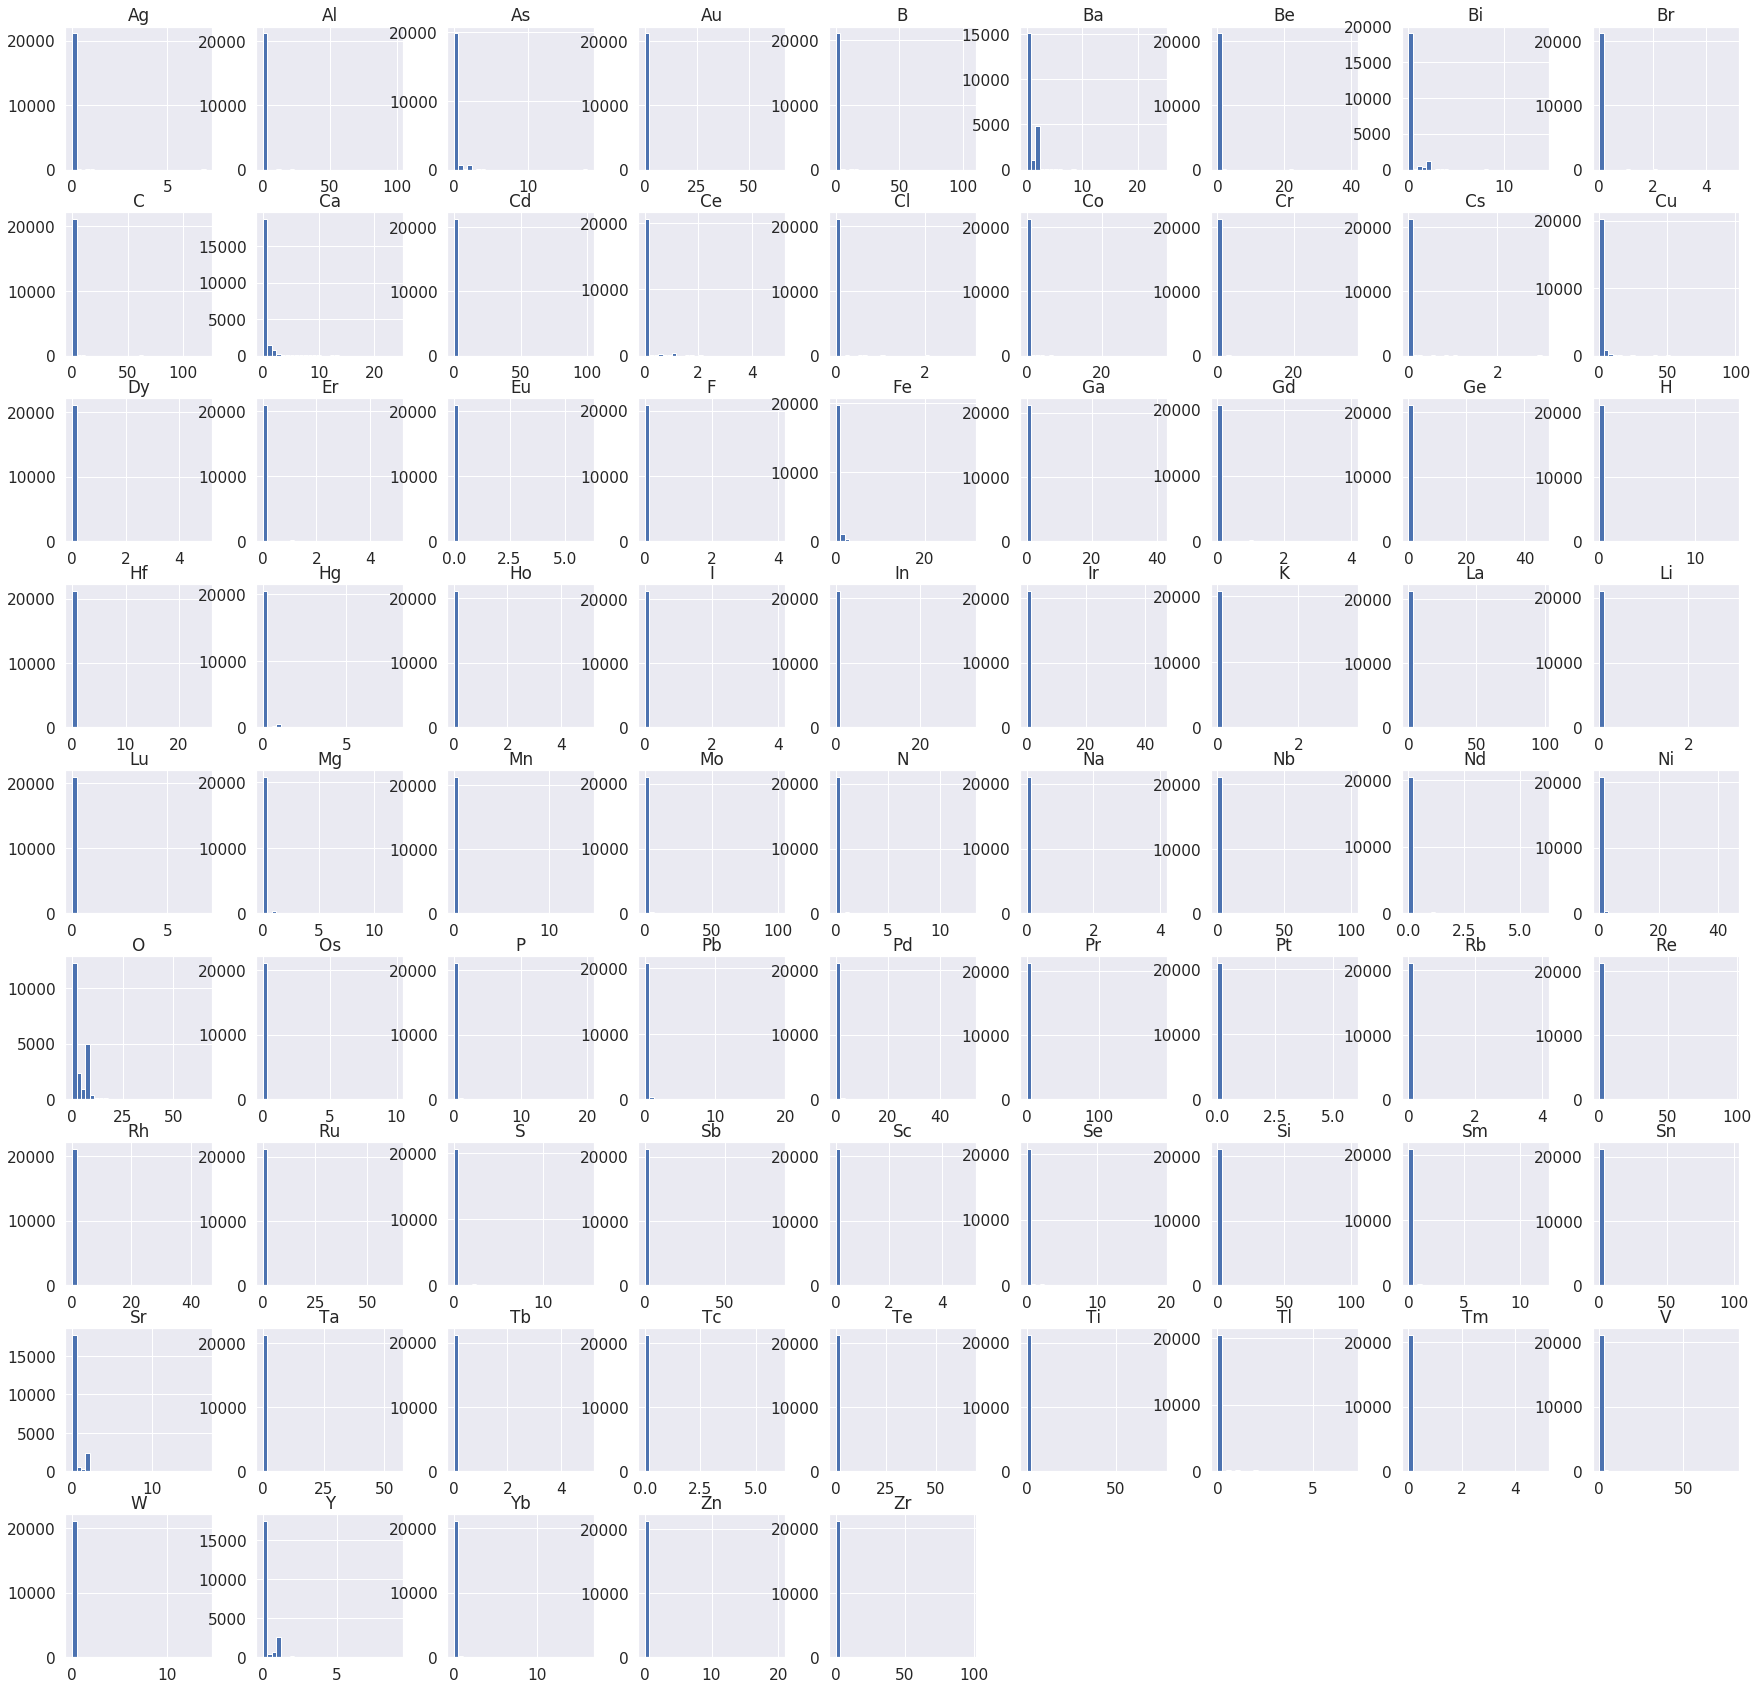

In [22]:
formulas_.hist(bins=30, figsize=(30, 30))
plt.show()

### Part 3. Metrics selection 

This is regression problem. Our target metric will be MAE - it is one of the most popular regression metrics, and it has same unit of measurement as target value thus is easy to explain to other people.

$$\begin{align}
MAE = \frac{1}{n}\Sigma_{i=1}^{n}{\Big|{d_i -f_i}\Big|}
\end{align}$$

MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

### Part 4. Data preprocessing

In [23]:
# Create train and test splits

X_train, X_test, \
X_train_elem, X_test_elem,\
y_train, y_test = train_test_split(data[features_list+log_features],
                                   formulas_,
                                   data['critical_temp'],
                                   test_size=0.1,
                                   shuffle=True, random_state=42)

# Shapes:
X_train.shape, X_test.shape, X_train_elem.shape, X_test_elem.shape, y_train.shape, y_test.shape

((19136, 41), (2127, 41), (19136, 77), (2127, 77), (19136,), (2127,))

In [24]:
X_train_combo = pd.concat([X_train, X_train_elem], axis=1, sort=False)
X_test_combo = pd.concat([X_test, X_test_elem], axis=1, sort=False)

In [25]:
# Scale the data:

scaler = StandardScaler()

X_train_combo_scaled = scaler.fit_transform(X_train_combo)
X_test_combo_scaled = scaler.transform(X_train_combo)

In [26]:
X_train_combo.shape

(19136, 118)

In [27]:
# Linear Regression:

linearmodel = LinearRegression()

pipeline = Pipeline([('scaler', scaler),
                     ('linear_reg', linearmodel)])

print('MAE (all features): ',
      -np.mean(cross_val_score(pipeline, X_train_combo, y_train, cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=0)))
print()
print('MAE (all features + log1p(target)): ',
      -np.mean(cross_val_score(pipeline, X_train_combo, y_train.apply(np.log1p),
                               cv=5, scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=0)))

MAE (all features):  13.906903492320044

MAE (all features + log1p(target)):  0.511578605535284


Compare this with the best constant prediction - what if we always predict mean temperature:

In [28]:
print('Baseline MAE: ', mean_absolute_error(y_train,
                                             np.ones(y_train.shape)*np.mean(y_train)))

Baseline MAE:  29.365277803069716


##### Conclusions:

* simple linear regression model much better than always predicting mean critical temperature
* applying function $log(1+n)$ on the target feature improve model performance

In [29]:
# Using other features:

print('MAE (only chemical elements info + log1p(target)): ',
      -np.mean(cross_val_score(pipeline, X_train_elem,
                               y_train.apply(np.log1p), cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=0)))
print()
print('MAE (only physics features + log1p(target)): ',
      -np.mean(cross_val_score(pipeline, X_train,
                               y_train.apply(np.log1p), cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=0)))
print()
print('MAE (without log features + log1p(target)): ', 
      -np.mean(cross_val_score(pipeline,
                               X_train_combo.drop(log_features, axis=1),
                               y_train.apply(np.log1p), cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=0)))
print()
print('MAE (without high correlated features + log1p(target)): ', 
      -np.mean(cross_val_score(pipeline,
                               X_train_combo.drop(to_drop, axis=1),
                               y_train.apply(np.log1p), cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=0)))

MAE (only chemical elements info + log1p(target)):  0.6581769451902048

MAE (only physics features + log1p(target)):  0.544956311344829

MAE (without log features + log1p(target)):  0.5137231893775205

MAE (without high correlated features + log1p(target)):  0.5241708800568634


### Part 5. Model selection.

I will try to solve the problem with 3 different regression models:

* Linear regression
* Random forest
* Gradient boosting

Linear regression is fast, simple and can provide quite a good baseline result for our task. Tree-based models can provide better results in case of nonlinear complex dependences of variables and in case of a small number of variables, they are also more stable to multicollinearity (and we have highly correlated variables).

Tree-based models are expected to work better in this particular problem, but it's a good behavior to start with some simple model.

I will start with Lasso regression, go through all of the modeling steps, and then do some simplified computations for 2 other models (without in-depth explanation of every step).

The final model selection will be done based on the results.

### Part 5.1 Lasso Regression

In [30]:
# Lasso model:

model_lasso = Lasso(random_state=42)

pipeline = Pipeline([('scaler', scaler),
                     ('lasso', model_lasso)])

print('Lasso model. MAE (without high correlated features + log1p(target)): ',
      -np.mean(cross_val_score(pipeline,
                               X_train_combo.drop(to_drop, axis=1),
                               y_train.apply(np.log1p), cv=5,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1, verbose=0)))

Lasso model. MAE (without high correlated features + log1p(target)):  1.1161009736032095


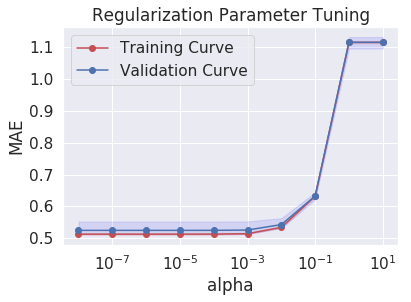

In [31]:
# Tunning alpha parameter for Lasso model:

alphas=np.logspace(-8, 1, 10)
train_scores, valid_scores = validation_curve(pipeline, X_train_combo.drop(to_drop, axis=1), 
                                              y_train.apply(np.log1p), "lasso__alpha", 
                                              alphas, cv=7, scoring='neg_mean_absolute_error')

plt.plot(alphas, -train_scores.mean(axis=1), 'ro-', label='Training Curve')

plt.fill_between(x=alphas, y1=-train_scores.max(axis=1), 
                 y2=-train_scores.min(axis=1), alpha=0.1, color = "red")


plt.plot(alphas, -valid_scores.mean(axis=1), 'bo-', label='Validation Curve')

plt.fill_between(x=alphas, y1=-valid_scores.max(axis=1), 
                 y2=-valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('Regularization Parameter Tuning')
plt.legend()

plt.show()

In [32]:
best_a = alphas[np.argmin(-valid_scores.mean(axis=1))]
print('Best alpha: ', best_a)
print('Best Validation MAE: ', np.min(-valid_scores.mean(axis=1)))

Best alpha:  1e-08
Best Validation MAE:  0.5241968458130194


In [33]:
# First stable alpha:

sorted(alphas)[5]

0.001

Curves for train and CV are very close to each other, it is a sign of underfitting. The difference between the curves does not change along with the change in alpha this mean that should try more complex models comparing to linear regression or use more features (f.e. polynomial ones)

Using this curve we can find the optimal value of alpha. It is alpha=1.e-08 (by the way, even alpha=0.001 good enough).

Let's use  $alpha=0.001$  and plot the learning curve:

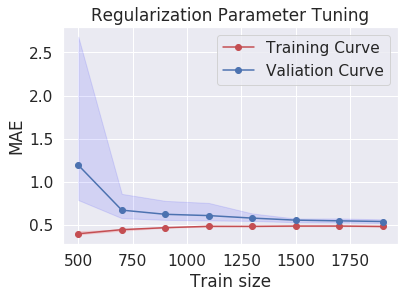

In [34]:
model_lasso = Lasso(alpha=0.001, random_state=42)

pipeline = Pipeline([('scaler', scaler),
                     ('lasso', model_lasso)])

train_sizes, train_scores, valid_scores = learning_curve(pipeline, X_train_combo.drop(to_drop, axis=1),
                                                         y_train.apply(np.log1p),
                                                         train_sizes=list(range(500,2000,200)),
                                                         scoring='neg_mean_absolute_error', cv=5)

plt.plot(train_sizes, -train_scores.mean(axis=1), 'ro-', label='Training Curve')

plt.fill_between(x=train_sizes, y1=-train_scores.max(axis=1), 
                 y2=-train_scores.min(axis=1), alpha=0.1, color = "red")

plt.plot(train_sizes, -valid_scores.mean(axis=1), 'bo-', label='Valiation Curve')

plt.fill_between(x=train_sizes, y1=-valid_scores.max(axis=1), 
                 y2=-valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xlabel('Train size')
plt.ylabel('MAE')
plt.title('Regularization Parameter Tuning')
plt.legend()

plt.show()

Learning curves indicate the high bias of the model - this means we will not improve our model by adding more data, but we can try to use more complex models to improve the results.

In [35]:
# Fit-predict:

Lasso_CV_score = -np.mean(cross_val_score(pipeline,
                                           X_train_combo.drop(to_drop, axis=1),
                                          y_train.apply(np.log1p), cv=5,
                                          scoring='neg_mean_absolute_error',
                                          n_jobs=-1, verbose=0))

pipeline.fit(X_train_combo.drop(to_drop, axis=1), y_train.apply(np.log1p))
y_hat = pipeline.predict(X_test_combo.drop(to_drop, axis=1))
Lasso_HO_score = mean_absolute_error(y_hat, y_test.apply(np.log1p))

print('Lasso cross-val score:', Lasso_CV_score)
print('Lasso hold-out score:', Lasso_HO_score)

Lasso cross-val score: 0.5252090768809287
Lasso hold-out score: 0.5204317767733908


### Part 5.2 Random Forest

In [36]:
# Model initialization:

model_rf=RandomForestRegressor(n_estimators=100, random_state=42)

In [37]:
%%time
# Random Forest "from the box" with target feature:

cv_scores = cross_val_score(model_rf, X_train_combo.drop(log_features, axis=1), 
                            y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

print('MAE: ', -cv_scores.mean())

MAE:  5.261893201799741
CPU times: user 96.7 ms, sys: 27.9 ms, total: 125 ms
Wall time: 4min 9s


In [38]:
%%time
# Random Forest with function log(n+1) applyed on target feature:

cv_scores = cross_val_score(model_rf, X_train_combo.drop(log_features, axis=1), 
                            y_train.apply(np.log1p), cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

print('MAE: ',-cv_scores.mean())

MAE:  0.21385340771008932
CPU times: user 107 ms, sys: 23.9 ms, total: 131 ms
Wall time: 4min 1s


There is a significant improvement in score, but train time is also increased, comparing with Lasso model.

In [39]:
# Feature importances:

model_rf.fit(X_train_combo.drop(log_features, axis=1), y_train.apply(np.log1p))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

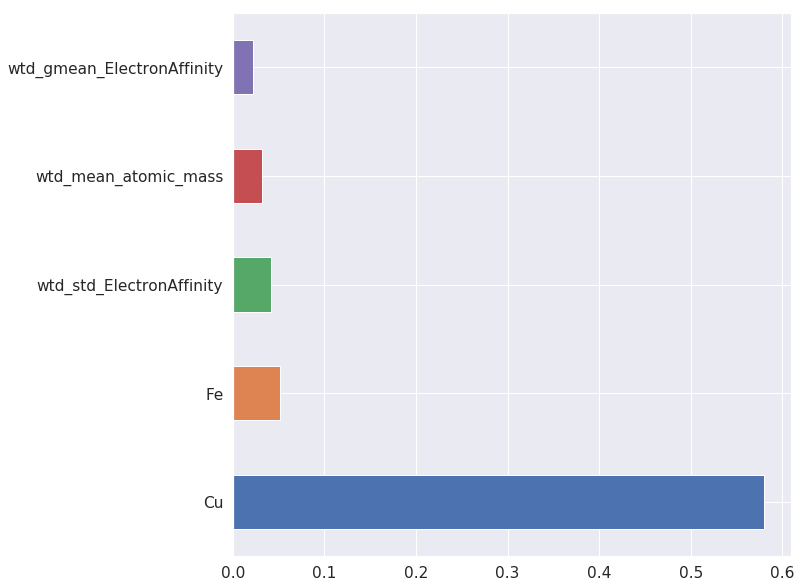

In [40]:
features_imp = (dict((k, v) for k, v in zip(list(X_train_combo.drop(log_features, axis=1).columns),
                                                        model_rf.feature_importances_)))

plt.figure(figsize=[10, 10])
(pd.Series(model_rf.feature_importances_,
           index=X_train_combo.drop(log_features, axis=1).columns).nlargest(5).plot(kind='barh'))

The most significant feature of superconductor is Cu (copper) in material.

In [41]:
# Parameter tunning:

param_grid={'max_depth':  [5, 10, 15, 25, 30, 35],
            'max_features': [20, 30, 60, 70, 80, 90, 100, 113]}

gs_rf=GridSearchCV(model_rf, param_grid, scoring='neg_mean_absolute_error',
                fit_params=None, n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(X_train_combo.drop(log_features, axis=1), y_train.apply(np.log1p))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 82.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 25, 30, 35], 'max_features': [20, 30, 60, 70, 80, 90, 100, 113]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [42]:
print('best params')
print(gs_rf.best_params_)
print('best score')
print(-gs_rf.best_score_)

best params
{'max_depth': 30, 'max_features': 90}
best score
0.21361364901619542


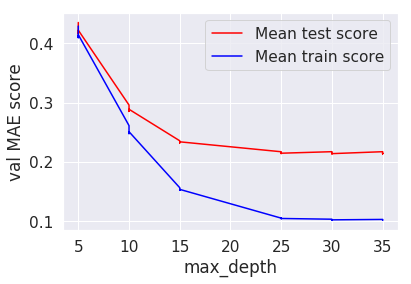

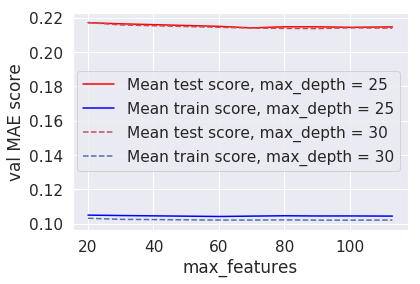

In [53]:
# Logs

log = pd.DataFrame(gs_rf.cv_results_)[['param_max_depth',
                                       'param_max_features',
                                       'mean_test_score',
                                       'mean_train_score']]

plt.plot(log['param_max_depth'], -log['mean_test_score'], label='Mean test score',
        color = "red")
plt.plot(log['param_max_depth'], -log['mean_train_score'], label='Mean train score',
        color = "blue")
plt.ylabel('val MAE score')
plt.xlabel('max_depth')
plt.legend()
plt.show()

plt.plot(log[log['param_max_depth'] == 25]['param_max_features'],
         -log[log['param_max_depth'] == 25]['mean_test_score'],
         label='Mean test score, max_depth = 25', color = "red")
plt.plot(log[log['param_max_depth'] == 25]['param_max_features'], 
         -log[log['param_max_depth'] == 25]['mean_train_score'],
         label='Mean train score, max_depth = 25', color = "blue")
plt.plot(log[log['param_max_depth'] == 30]['param_max_features'],
         -log[log['param_max_depth'] == 30]['mean_test_score'],
         'r--', label='Mean test score, max_depth = 30')
plt.plot(log[log['param_max_depth'] == 30]['param_max_features'], 
         -log[log['param_max_depth'] == 30]['mean_train_score'],
         'b--', label='Mean train score, max_depth = 30')
plt.ylabel('val MAE score')
plt.xlabel('max_features')
plt.legend()
plt.show()

The max_features parameter practically doesn't improve performance, it's almost stable, but max_depth=25 seems to be optimal.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 60.3min finished


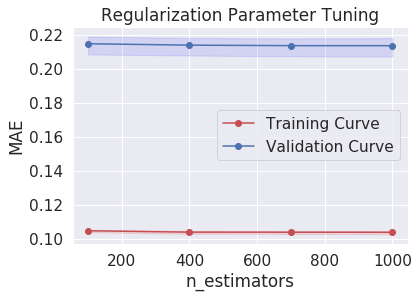

In [54]:
# Validation curve:

model_rf=RandomForestRegressor(n_estimators=100,
                               max_depth=25,
                               max_features=90,
                               random_state=42)

n_estim=list(range(100,1001,300))
train_scores, valid_scores = validation_curve(model_rf, X_train_combo.drop(log_features, axis=1), 
                                              y_train.apply(np.log1p), 'n_estimators', 
                                              n_estim, cv=5, scoring='neg_mean_absolute_error',
                                             verbose=1,
                                             n_jobs=-1)

plt.plot(n_estim, -train_scores.mean(axis=1), 'ro-', label='Training Curve')

plt.fill_between(x=n_estim, y1=-train_scores.max(axis=1), 
                 y2=-train_scores.min(axis=1), alpha=0.1, color = "red")


plt.plot(n_estim, -valid_scores.mean(axis=1), 'bo-', label='Validation Curve')

plt.fill_between(x=n_estim, y1=-valid_scores.max(axis=1), 
                 y2=-valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.title('Regularization Parameter Tuning')
plt.legend()

plt.show()

In [55]:
best_n = n_estim[np.argmin(-valid_scores.mean(axis=1))]
print('Best number of tree: ', best_n)
print('Best Validation MAE: ', np.min(-valid_scores.mean(axis=1)))

Best number of tree:  1000
Best Validation MAE:  0.21350150626822587


This time we can see that the results of train is much better than CV, but it is totally ok for the Random Forest.

Higher value of n_estimators (>100) does not help much. Let's stick to the n_estimators=100 - it is high enough but not very computationally intensive.

In [57]:
# Fit-predict:

RandForest_CV_score = -np.mean(cross_val_score(model_rf,
                                               X_train_combo.drop(log_features, axis=1),
                                               y_train.apply(np.log1p), cv=5,
                                               scoring='neg_mean_absolute_error',
                                               n_jobs=-1, verbose=0))

model_rf.fit(X_train_combo.drop(log_features, axis=1), y_train.apply(np.log1p))
y_hat = model_rf.predict(X_test_combo.drop(log_features, axis=1))
RandForest_HO_score = mean_absolute_error(y_hat, y_test.apply(np.log1p))

print('RandomForest cross-val score:', RandForest_CV_score)
print('RandomForest hold-out score:', RandForest_HO_score)

RandomForest cross-val score: 0.21465339623557012
RandomForest hold-out score: 0.20229345687919717


### Part 5.3 Gradient boosting

In [58]:
# XGBRegressor:

xgb_model = XGBRegressor(max_depth=25, learning_rate=0.1, 
                         n_estimators=100, n_jobs=-1,
                         eval_metric='mae', seed=42)

print('XGBoost MAE: ', -np.mean(cross_val_score(xgb_model,
                                                X_train_combo.drop(log_features, axis=1),
                                                y_train.apply(np.log1p), cv=5,
                                                scoring='neg_mean_absolute_error',
                                                n_jobs=-1, verbose=1)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


XGBoost MAE:  0.21269969394738703


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


In [59]:
%%time
xgb_model.fit(X_train_combo.drop(log_features, axis=1), y_train.apply(np.log1p))

CPU times: user 3min 7s, sys: 152 ms, total: 3min 7s
Wall time: 48.3 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=25, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1)

XGBRegressor model performs much faster then RandomForest and give a little better MAE. Parameter tunning can halp improve performance.

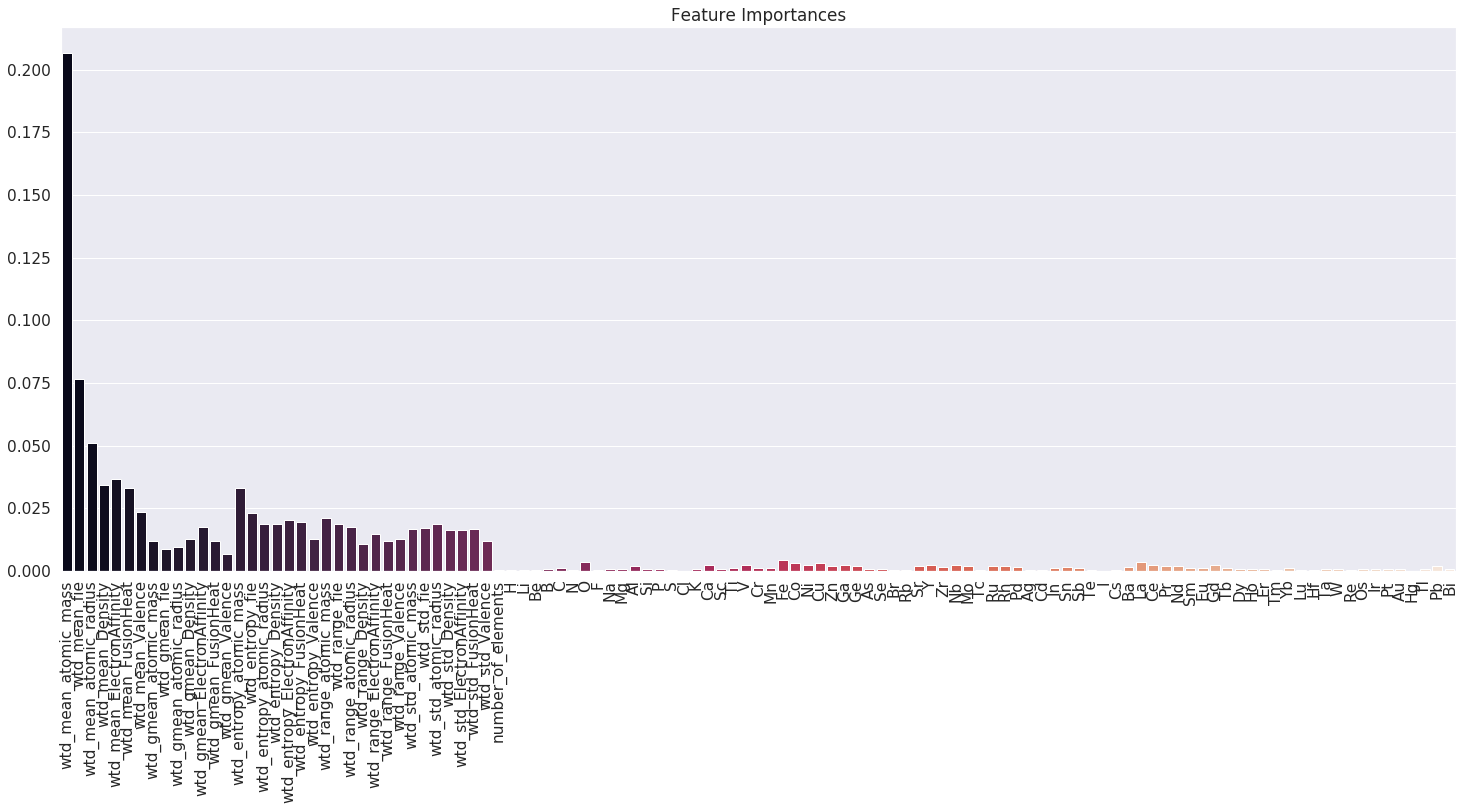

In [60]:
# Feature importances:

plt.figure(figsize=[25, 10])
ax = sns.barplot(list(X_train_combo.drop(log_features, axis=1).columns),
            xgb_model.feature_importances_,
            palette="rocket", 
           )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Feature Importances')
plt.show()

In [65]:
# Parameter tuning:

parameters_for_testing = {
    'colsample_bytree':[0.4,0.8],
    'gamma':[0, 0.1],
    'min_child_weight':[1.5,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[25],
    'reg_alpha':[1e-5, 0.75],
    'reg_lambda':[1e-5, 0.45],
    'subsample':[0.6,0.95]  
}

xgb_model = XGBRegressor(max_depth=25, learning_rate=0.1, 
                         n_estimators=100, n_jobs=-1,
                         eval_metric='mae', seed=42)

gs_xgb_model = GridSearchCV(estimator = xgb_model,
                            param_grid=parameters_for_testing,
                            n_jobs=-1, iid=False,
                            verbose=1,
                            scoring='neg_mean_absolute_error')

gs_xgb_model.fit(X_train_combo.drop(log_features, axis=1), y_train.apply(np.log1p))

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 41.5min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 112.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=25, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'colsample_bytree': [0.4, 0.8], 'gamma': [0, 0.1], 'min_child_weight': [1.5, 10], 'learning_rate': [0.1, 0.07], 'max_depth': [25], 'reg_alpha': [1e-05, 0.75], 'reg_lambda': [1e-05, 0.45], 'subsample': [0.6, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [66]:
print('best params')
print(gs_xgb_model.best_params_)
print('best score')
print(-gs_xgb_model.best_score_)

best params
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.07, 'max_depth': 25, 'min_child_weight': 1.5, 'reg_alpha': 1e-05, 'reg_lambda': 0.45, 'subsample': 0.95}
best score
0.21540303747273057


In [71]:
xgb_model = XGBRegressor(colsample_bytree=0.8,
                         gamma=0,
                         learning_rate=0.07,
                         max_depth=25,
                         min_child_weight=1.5,
                         reg_alpha=1e-05,
                         reg_lambda=0.45,
                         subsample=0.95,
                         n_estimators=100,
                         n_jobs=-1,
                         eval_metric='mae',
                         seed=42)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 66.5min finished


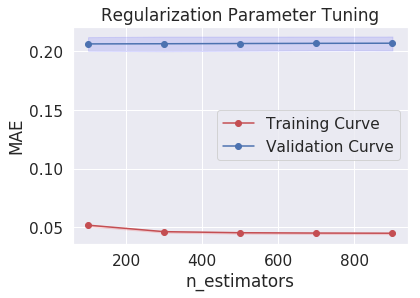

In [72]:
# Validation curve:

n_estim=list(range(100,1001,200))
train_scores, valid_scores = validation_curve(xgb_model, X_train_combo.drop(log_features, axis=1), 
                                              y_train.apply(np.log1p), 'n_estimators', 
                                              n_estim, cv=5, scoring='neg_mean_absolute_error',
                                             verbose=1,
                                             n_jobs=-1)

plt.plot(n_estim, -train_scores.mean(axis=1), 'ro-', label='Training Curve')

plt.fill_between(x=n_estim, y1=-train_scores.max(axis=1), 
                 y2=-train_scores.min(axis=1), alpha=0.1, color = "red")


plt.plot(n_estim, -valid_scores.mean(axis=1), 'bo-', label='Validation Curve')

plt.fill_between(x=n_estim, y1=-valid_scores.max(axis=1), 
                 y2=-valid_scores.min(axis=1), alpha=0.1, color = "blue")

plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.title('Regularization Parameter Tuning')
plt.legend()
plt.show()

In [73]:
best_n = n_estim[np.argmin(-valid_scores.mean(axis=1))]
print('Best number of tree: ', best_n)
print('Best Validation MAE: ', np.min(-valid_scores.mean(axis=1)))

Best number of tree:  100
Best Validation MAE:  0.2064737573149639


In [75]:
# Fit-predict:

xgb_model_CV_score = -np.mean(cross_val_score(xgb_model,
                                               X_train_combo.drop(log_features, axis=1),
                                               y_train.apply(np.log1p), cv=5,
                                               scoring='neg_mean_absolute_error',
                                               n_jobs=-1, verbose=0))

xgb_model.fit(X_train_combo.drop(log_features, axis=1), y_train.apply(np.log1p))
y_hat = xgb_model.predict(X_test_combo.drop(log_features, axis=1))
xgb_model_HO_score = mean_absolute_error(y_hat, y_test.apply(np.log1p))

print('Gradient Boosting cross-val score:', xgb_model_CV_score)
print('Gradient Boosting hold-out score:', xgb_model_HO_score)

Gradient Boosting cross-val score: 0.2064737573149639
Gradient Boosting hold-out score: 0.19237646922378007


### Part 6. Conclusions

In [79]:
# Pivot table

my_dict = {
    'Algorithm': ['Lasso',
                  'RandomForest',
                  'XGBRegressor'],
    'Cross-Validation MAE': [Lasso_CV_score,
                             RandForest_CV_score, 
                             xgb_model_CV_score],
    'Hold-out MAE': [Lasso_HO_score,
                     RandForest_HO_score,
                     xgb_model_HO_score]
              }

pv_table = pd.pivot_table(pd.DataFrame.from_dict(my_dict),
                             values=['Cross-Validation MAE',
                                     'Hold-out MAE'],
                             columns=['Algorithm'])
pv_table.head()

Algorithm,Lasso,RandomForest,XGBRegressor
Cross-Validation MAE,0.525209,0.214653,0.206474
Hold-out MAE,0.520432,0.202293,0.192376


Cross validation results are inline with holdout ones. The best CV model - Gradient Boosting, turned out to be the best on hold-out dataset as well (and it is also faster than Random Forest).